# Test run of whole project

In [1]:
%run src\project\Global_nav.py
%run src\project\DetectionFcts.py
%run src\project\Locomotion.py

In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 2c7350d0-9e66-4eb8-9b25-c07ee89089f8

In [3]:
def main(checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) :
    global current_checkpoint_index, fsm_state, cam_available, cam_data, x_est_prev, P_est_prev, reached_end, speed
    """
    Main function which coordinates the whole application
    
    global : takes the variables that will be changed throughout the application
    
    param checkpoints_data: velocity of left wheel as decided by control law in metric [mm/s]
    param Q: Q matrix for the Kalman Filter
    param R: R matrix for the Kalman Filter
    param Ts: Period for the Python thread which uses the main(...) function
    
    no return 
    """
    if webcam:
        success,img = cap.read()
        cam_available = True
    else: 
        cam_available = False
    
    if cam_available:
        Thymio_coord, Thymio_found = analyse_thymio(img,contours, area_max, m.ratio_downscale)
    
    if (Thymio_found):
        corrected_estimate_angle = -Thymio_coord[2]
        if corrected_estimate_angle < 0 :
            corrected_estimate_angle = corrected_estimate_angle +2*math.pi
        Thymio_coord = (Thymio_coord[0]*m.ratio_total, (m.height-Thymio_coord[1])*m.ratio_total, corrected_estimate_angle)
    else:
        Thymio_coord = np.array([0,0,0])
    [x_est_prev, P_est_prev] = kalman_filter(speed, Thymio_found, Thymio_coord, x_est_prev, P_est_prev, Q, R, Ts)
    
    sensor_data = np.array(node.v.prox.horizontal[0:5]) #get data from horiz proximity sensors
    
    [left_velocity, right_velocity, fsm_state, current_checkpoint_index, reached_end] = control_law(sensor_data, checkpoints_data, current_checkpoint_index, fsm_state, x_est_prev, Thymio_found)
    print('Checkpoint number : '+str(current_checkpoint_index) + '\n')
    print('FSM state : '+str(fsm_state) + '\n \n')
    
    speed = [left_velocity, right_velocity]
    
    node.send_set_variables(motors(left_velocity, right_velocity))
    cam_avaiable = False 
    Thymio_found = False

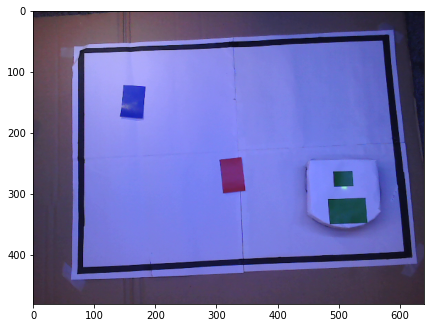

Satisfying Image ? : n


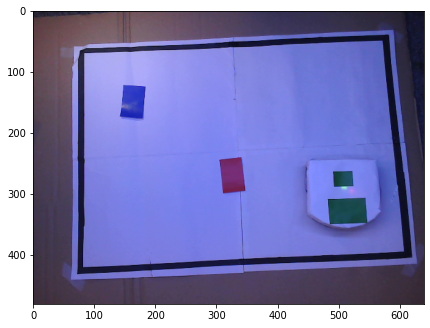

Satisfying Image ? : n


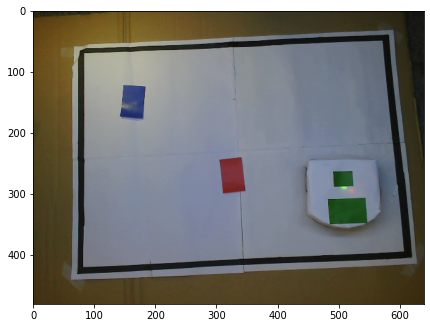

Satisfying Image ? : y
End position not found


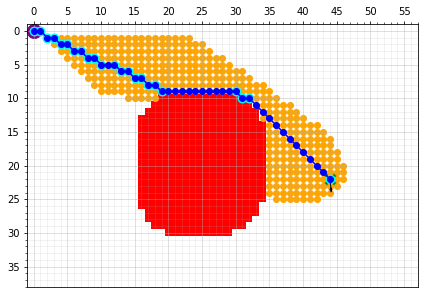

Satisfying analysis ? : n


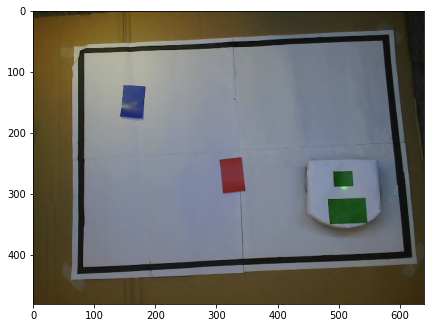

Satisfying Image ? : n


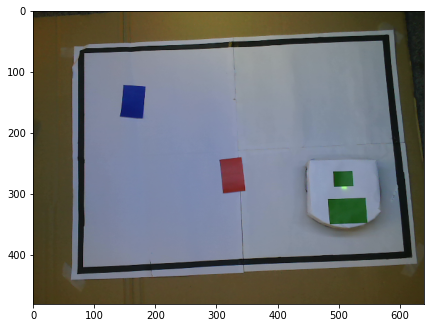

Satisfying Image ? : n


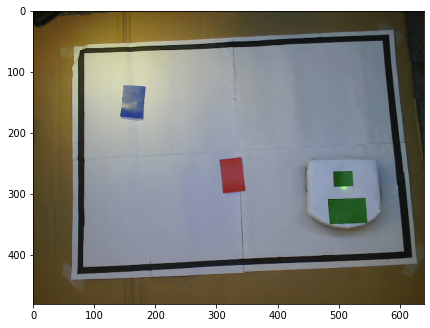

Satisfying Image ? : y


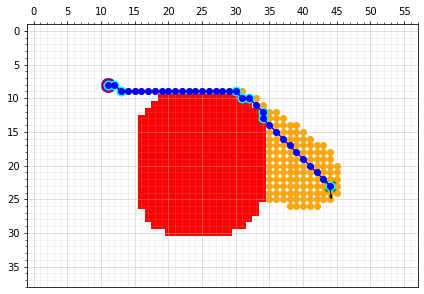

Satisfying analysis ? : y
Didn't use Kalman 

Estimated orientation : 278.7461622625552

Angle wanted : 315.00000000000017

Checkpoint number : 1

FSM state : rotating
 

Thymio not found
Didn't use Kalman 

Estimated orientation : 0.0

Angle wanted : 339.07549825507886

Checkpoint number : 1

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 275.4923245571274

Angle wanted : 138.01278750418334

Checkpoint number : 1

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 278.13010235415595

Angle wanted : 135.0

Checkpoint number : 1

FSM state : rotating
 

Thymio not found
Didn't use Kalman 

Estimated orientation : 0.0

Angle wanted : 339.07549825507886

Checkpoint number : 1

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 273.50353164478446

Angle wanted : 135.0

Checkpoint number : 1

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 272.2906100426385

Angle wanted : 135.0

Checkpoint number : 1

FSM state : ro

Didn't use Kalman 

Estimated orientation : 141.51980175165698

Angle wanted : 134.99999999999997

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 321.7098368077569

Angle wanted : 134.99999999999997

Checkpoint number : 1

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 142.43140797117252

Angle wanted : 135.0

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 144.46232220802563

Angle wanted : 138.81407483429035

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 142.6960517220166

Angle wanted : 135.0

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 143.13010235415598

Angle wanted : 135.0

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 143.13010235415598

Angle wanted : 135.0

Checkpoint number : 1

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 

Didn't use Kalman 

Estimated orientation : 177.6140559696112

Angle wanted : 186.3401917459099

Checkpoint number : 6

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 180.0

Angle wanted : 186.3401917459099

Checkpoint number : 6

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 176.42366562500266

Angle wanted : 187.12501634890177

Checkpoint number : 6

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 177.56335175318986

Angle wanted : 187.12501634890177

Checkpoint number : 6

FSM state : moving
 

Didn't use Kalman 

Estimated orientation : 176.49646835521557

Angle wanted : 188.13010235415595

Checkpoint number : 6

FSM state : moving
 

Thymio not found
Didn't use Kalman 

Estimated orientation : 0.0

Angle wanted : 325.304846468766

Checkpoint number : 6

FSM state : rotating
 

Didn't use Kalman 

Estimated orientation : 178.80651057601798

Angle wanted : 191.30993247402017

Checkpoint number : 6

FSM state : moving
 

Didn't

In [4]:
import os
import sys
import math
from statistics import mean
import numpy as np
import cv2
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline


# Camera intialisation
webcam = True
cap = cv2.VideoCapture(1)
cap.open(1, cv2.CAP_DSHOW)

# While loop to get a proper first image
while True:
    if webcam:
        success,img = cap.read()
        plt.figure(figsize=(7, 7))
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.show()
        
    keypress1 = input("Satisfying Image ? : ")
    if keypress1 =="y":
        m, contours, area_max = analyse(img)
        keypress2 = input("Satisfying analysis ? : ")
        if keypress2 =="y":
            break

### Control Law parameters intialization
checkpoints_data = m.checkpoints.transpose()*m.ratio_total # checkpoints converted to mm
length_checkpoint = np.size(checkpoints_data, 0)
for i in range(length_checkpoint):
    # adjusting checkpoints due to different references
    checkpoints_data[i][1] = m.height*m.ratio_total - checkpoints_data[i][1] 

current_checkpoint_index = 0
fsm_state = "starting"
left_velocity = 0
right_velocity = 0 
speed = [0, 0]

### Kalman filter parameters initalization
corrected_start_angle = -m.start[2]
if corrected_start_angle < 0 :
    corrected_start_angle = corrected_start_angle + 2*math.pi
    
x_init = np.array([m.start[0]*m.ratio_total, (m.height-m.start[1])*m.ratio_total, corrected_start_angle])
P_init = np.diag([0.45, 0.45, 0.4])
x_est_prev = x_init 
P_est_prev = P_init

Q = np.diag([0.3, 0.3, 0.5])                  
R = np.diag([0.7, 0.7, 0.9])

### End of application bool
reached_end = False

### Thread parameter
Ts = 0.2

timer = RepeatedTimer(Ts, main, checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) # it auto-starts, no need of rt.start()   

try:
    while not(reached_end) : 
        await node.wait_for_variables() # wait for Thymio variables values
        await client.sleep(1)
finally:
    timer.stop() 
    print('Application has finished, bye bye !')


In [5]:
#Now unlock the robot:
await node.unlock()